## Proyecto: "Evaluación de los resultados de la prueba A/B del nuevo mecanismo de recomendaciones en el sitio web de una tienda en línea"

Del 7 de diciembre de 2020 al 4 de enero de 2021 se llevó a cabo una prueba A/B de una nueva funcionalidad, específicamente un nuevo mecanismo de recomendaciones en el sitio web de una tienda en línea.

Se planteó la tarea de analizar los resultados de la prueba. Dentro del ámbito de esta tarea se prevé realizar las siguientes actividades:

1.  Verificación de la corrección de los datos y su preprocesamiento.
2.  Análisis exploratorio de los resultados de la prueba.
3.  Formulación de conclusiones sobre la calidad y los resultados del estudio.

-   Para el análisis de los resultados se proporcionaron 4 conjuntos de datos, que contienen la siguiente información:

    -   ab_project_marketing_events.csv — calendario de eventos de marketing para el año 2020 con la siguiente estructura:
    -   name — nombre del evento de marketing;
    -   regions — regiones donde se llevará a cabo la campaña publicitaria;
    -   start_dt — fecha de inicio de la campaña;
    -   finish_dt — fecha de finalización de la campaña.
-   final_ab_new_users.csv — usuarios registrados del 7 al 21 de diciembre de 2020 con la siguiente estructura:
    -   user_id — identificador del usuario;
    -   first_date — fecha de registro;
    -   region — región del usuario;
    -   device — dispositivo desde el cual se realizó el registro.
-   final_ab_events.csv — acciones de los nuevos usuarios en el período del 7 de diciembre de 2020 al 4 de enero de 2021 con la siguiente estructura:
    -   user_id — identificador del usuario;
    -   event_dt — fecha y hora del evento;
    -   event_name — tipo de evento;
    -   details — datos adicionales sobre el evento. Por ejemplo, para las compras, 'purchase', en este campo se almacena el costo de la compra en dólares.
-   final_ab_participants.csv — tabla de participantes en las pruebas con la siguiente estructura:
    -   user_id — identificador del usuario;
    -   ab_test — nombre de la prueba;
    -   group — grupo del usuario.

## Preparación
### Importación de bibliotecas y lectura de datos.

In [1]:
import pandas as pd
from io import BytesIO
import requests
import math as mth
import scipy.stats as st
from plotly import graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import psutil
import plotly.io as pio
pio.renderers.default='notebook'

from IPython.display import Image

In [2]:
# Importamos las tablas

spreadsheet_id = '17FYfKzEDrS0wbzzvB8UVuy_5Vgzld8R_R-2xZF2AJV0'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id) # TODO Te recomiendo usar f-strings en vez de format. Es más legible.
r = requests.get(file_name)
final_ab_participants = pd.read_csv(BytesIO(r.content))

spreadsheet_id = '1ieuhv8ajykMdbc8WAcM1vvX-gpsE64loavBqyGcSopk'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
final_ab_events = pd.read_csv(BytesIO(r.content))

spreadsheet_id = '1AtN5QdkpmRMD1DYtzCgSIe0-QV_9XBHiPQDzrRr_vE0'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
final_ab_new_users = pd.read_csv(BytesIO(r.content))

spreadsheet_id = '1GY05m4U132se59Cn_4734p5u6L_OfJDA6_wbnxdEB7E'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
ab_project_marketing_events = pd.read_csv(BytesIO(r.content))

## Preprocesamiento de datos
### Tabla final_ab_participants

In [3]:
# Vamos a revisar el tamaño de la tabla y los tipos de datos
final_ab_participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


In [4]:
# Evaluación de la tabla
final_ab_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [5]:
# Evaluemos la agrupación de valores por el test y el grupo del test
final_ab_participants.groupby(['ab_test', 'group']).agg({'user_id': 'nunique'})

user_id
ab_test                 group         
interface_eu_test       A         5831
                        B         5736
recommender_system_test A         3824
                        B         2877

In [6]:
print('Cantidad de duplicados completos en los datos:', sum(final_ab_participants.duplicated()))


Cantidad de duplicados completos en los datos: 0


1.  La tabla contiene 18,268 filas y 3 columnas.
2.  No hay valores faltantes en las columnas.
3.  Los tipos de datos asignados automáticamente son correctos.
4.  La tabla incluye datos de dos pruebas diferentes - el estudio propone trabajar solo con una prueba.

## Tabla final_ab_new_users.

In [7]:
final_ab_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [8]:
final_ab_new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [9]:
# En la columna first_date se indica una fecha, pero está definida como tipo de datos de cadena, por lo tanto, realizaremos las conversiones necesarias.

final_ab_new_users['first_date'] = pd.to_datetime(final_ab_new_users['first_date'])

In [10]:
# Verifiquemos la presencia de duplicados.

print('Cantidad de duplicados completos en los datos:', sum(final_ab_new_users.duplicated()))

Cantidad de duplicados completos en los datos: 0


In [11]:
final_ab_new_users['first_date'].min()

print('Min fecha:',  final_ab_new_users['first_date'].min())
print('Max fecha:',  final_ab_new_users['first_date'].max())

Min дата: 2020-12-07 00:00:00
Max дата: 2020-12-23 00:00:00


In [12]:
final_ab_new_users = final_ab_new_users[final_ab_new_users['first_date'] <= '2020-12-21']

In [13]:
final_ab_new_users['region'].value_counts()

region
EU           42340
N.America     8347
CIS           2900
APAC          2883
Name: count, dtype: int64

In [14]:
final_ab_new_users['device'].value_counts()

device
Android    25161
PC         14310
iPhone     11477
Mac         5522
Name: count, dtype: int64

In [15]:
# Dejamos en el conjunto de datos solo a los usuarios de Europa, como lo requiere el documento de especificaciones técnicas (ТЗ).
final_ab_new_users = final_ab_new_users[final_ab_new_users['region'] == 'EU']

1.  En la tabla original hay 61,733 filas y 4 columnas.
2.  No hay valores faltantes.
3.  El tipo de datos de la columna first_date se ha convertido a fecha.
4.  En el conjunto de datos se encontraron fechas del 7 al 23 de diciembre de 2020. Según las especificaciones técnicas, la fecha de corte para la adquisición de nuevos usuarios es el 21 de diciembre de 2020, por lo tanto, se eliminaron todas las filas con fechas posteriores a esta.
5.  Se encontraron regiones distintas de "Europa" en el conjunto de datos. Como no necesitaremos estos datos para evaluar los resultados de la prueba, se eliminaron los datos de todas las regiones excepto Europa.

## Tabla final_ab_events.

In [16]:
final_ab_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   details     62740 non-null   float64
 3   event_name  440317 non-null  object 
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [17]:
final_ab_events.head()

,user_id,event_dt,details,event_name
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,99.99,purchase
1,7B6452F081F49504,2020-12-07 09:22:53,9.99,purchase
2,9CD9F34546DF254C,2020-12-07 12:59:29,4.99,purchase
3,96F27A054B191457,2020-12-07 04:02:40,4.99,purchase
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,4.99,purchase


In [18]:
# Verifiquemos la presencia de duplicados.
print('Cantidad de duplicados completos en los datos:', sum(final_ab_events.duplicated()))

Cantidad de duplicados completos en los datos: 0


In [19]:
# Vamos a convertir el texto en fecha.

final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt'])

In [20]:
print('Min Fecha de evento:',  final_ab_events['event_dt'].min())
print('Max Fecha de evento:',  final_ab_events['event_dt'].max())

Min Fecha de evento: 2020-12-07 00:00:33
Max Fecha de evento: 2020-12-30 23:36:33


In [21]:
# Presumiblemente, los datos en la columna details están presentes solo en las filas de eventos de compra, lo cual es lógico.
# Vamos a verificar esto mostrando la suma mínima.
final_ab_events.groupby('event_name', as_index=False).agg({'details': 'min'})

,event_name,details
0,login,NaN
1,product_cart,NaN
2,product_page,NaN
3,purchase,4.99


1.  La tabla contiene 440,317 registros y 4 columnas.
2.  No hay duplicados.
3.  No todos los valores están presentes en la columna details, ya que indica el monto de la compra, por lo tanto, los datos solo están disponibles en las transacciones que registraron una compra.
4.  Se requirió la conversión de la columna event_dt de tipo de datos string a fecha.
5.  Una observación interesante: según las especificaciones técnicas, el período de prueba concluyó el 4 de enero de 2021, aunque los datos de eventos solo están presentes hasta el 30 de diciembre inclusive. **Existe la posibilidad de que se haya perdido parte de los datos durante la descarga.**

## Tabla ab_project_marketing_events.

In [22]:
ab_project_marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 580.0+ bytes


In [23]:
ab_project_marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [24]:
ab_project_marketing_events['start_dt'] = pd.to_datetime(ab_project_marketing_events['start_dt'])
ab_project_marketing_events['finish_dt'] = pd.to_datetime(ab_project_marketing_events['finish_dt'])

1.  Se ha realizado la conversión de datos de tipo string a formato de fecha.


## Análisis de datos

### Análisis de la muestra de usuarios

Dado que la tarea principal es el análisis de eventos, compilaremos un dataframe universal con el que trabajaremos.

Como se especifica en el documento de especificaciones técnicas, estamos interesados en:

-   Nuevos usuarios registrados hasta el 21 de diciembre de 2020
-   Del área de la UE

Seleccionaremos a los usuarios de la región "Europa" de la tabla final_ab_new_users y adjuntaremos datos de los participantes del test de manera que solo se incluya la audiencia objetivo requerida.

In [25]:
# A la tabla con "nuevos" usuarios en la región "Europa", adjuntaremos los participantes de los tests y descartaremos los valores NaN.
users = final_ab_new_users.merge(
    final_ab_participants, on='user_id', how='left'
).dropna()

In [26]:
# De esta manera, obtenemos solo los datos necesarios.
users.head()

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
1,2E1BF1D4C37EA01F,2020-12-07,EU,PC,A,interface_eu_test
2,50734A22C0C63768,2020-12-07,EU,iPhone,B,interface_eu_test
7,E6DE857AFBDC6102,2020-12-07,EU,PC,B,recommender_system_test
8,E6DE857AFBDC6102,2020-12-07,EU,PC,B,interface_eu_test


In [27]:
# Vamos a verificar cómo se distribuyeron los usuarios por el test
users['ab_test'].value_counts()

ab_test
interface_eu_test          10565
recommender_system_test     6351
Name: count, dtype: int64

Revisaremos la lista de usuarios para detectar si hay intersecciones con participantes de otro test.



In [28]:
# Crearemos un dataframe en el cual guardaremos la cantidad de diferentes tests en los que participó cada usuario

two_tests_users = users.groupby('user_id', as_index=False).agg({'ab_test': 'nunique'})
two_tests_users = two_tests_users.rename(columns={'ab_test': 'number_of_tests'})
two_tests_users.head()

,user_id,number_of_tests
0,0002CE61FF2C4011,1
1,000ABE35EE11412F,1
2,001064FEAAB631A1,2
3,0010A1C096941592,1
4,001C05E87D336C59,1


In [29]:
# A continuación, seleccionamos a los usuarios que participaron en el AB-test objetivo.
recommender_system_test_users = users[users['ab_test'] == 'recommender_system_test']


In [30]:
# Adjuntaremos la cantidad de tests en los que cada usuario participó al dataframe con los participantes del test objetivo.
recommender_system_test_users = recommender_system_test_users.merge(two_tests_users, on='user_id', how='left')
recommender_system_test_users.head()

,user_id,first_date,region,device,group,ab_test,number_of_tests
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,1
1,E6DE857AFBDC6102,2020-12-07,EU,PC,B,recommender_system_test,2
2,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2
3,831887FE7F2D6CBA,2020-12-07,EU,Android,A,recommender_system_test,1
4,4CB179C7F847320B,2020-12-07,EU,iPhone,B,recommender_system_test,1


In [31]:

print('Participantes de dos tests en la muestra:', len(recommender_system_test_users[recommender_system_test_users['number_of_tests'] == 2]))
print('Tamaño de la muestra:', len(recommender_system_test_users))

Participantes de dos tests en la muestra: 1602
Tamaño de la muestra: 6351



El 25.2% de los participantes en el test de **recommender_system_test** también participaron en el segundo test, **interface_eu_test**. Según el nombre del segundo test y la uniformidad de los campos en la muestra de eventos, se espera que el efecto del texto de la interfaz también esté dirigido a aumentar la conversión. Por lo tanto, se ha identificado un segundo factor comprometedor.

Dado que sabemos que el grupo A actúa como el grupo de control en los tests, lo cual significa que utiliza funcionalidades que no han sido modificadas, podemos suponer que el grupo de control del **test interface_eu_test** podría ser utilizado en nuestro test de manera "segura".

In [32]:
two_tests_users.head()

,user_id,number_of_tests
0,0002CE61FF2C4011,1
1,000ABE35EE11412F,1
2,001064FEAAB631A1,2
3,0010A1C096941592,1
4,001C05E87D336C59,1


In [33]:
# Formamos dos conjuntos de datos en los que guardaremos los diferentes grupos del test competidor.
interface_eu_test_a = users[(users['ab_test'] == 'interface_eu_test') & (users['group'] == 'A')]
interface_eu_test_b = users[(users['ab_test'] == 'interface_eu_test') & (users['group'] == 'B')]

In [34]:
# Verificación de la proporción de participantes en el test:
print(
    'La proporción de participantes del test en relación con el total de nuevos usuarios de la región "Europa": {:.2f}%'.format(
        len(recommender_system_test_users)/len(final_ab_new_users[final_ab_new_users['region'] == 'EU'])*100)
)

La proporción de participantes del test en relación con el total de nuevos usuarios de la región "Europa": 15.00%


1.  Se ha realizado la verificación - efectivamente, en el test participan el 15% de los nuevos usuarios de la región EU, como lo requerían las especificaciones técnicas.
2.  Se ha formado un dataset con una muestra de 6351 usuarios que participaron en el test objetivo.
3.  También se han identificado usuarios que participaron simultáneamente en dos tests.

## Análisis de los resultados del test A/B.

In [35]:
# Formamos una tabla en la que solo quedarán los usuarios que forman parte del grupo de participantes del test.
ab_events = final_ab_events[final_ab_events['user_id'].isin(recommender_system_test_users['user_id'])]
print('Cantidad de eventos realizados por los usuarios que entran en la muestra de nuestro test:', len(ab_events))

Cantidad de eventos realizados por los usuarios que entran en la muestra de nuestro test: 23420


In [36]:
# Luego, vinculamos los eventos con los usuarios y obtenemos un único conjunto de datos donde podemos observar datos detallados por usuario.
ab_events = ab_events.merge(recommender_system_test_users, on='user_id', how='inner')

Realizaremos una verificación adicional de la cantidad de usuarios - para comprobar si para todos los usuarios de la muestra existen eventos en la tabla de operaciones.

In [37]:
print('Cantidad de identificadores únicos de usuarios en la tabla de eventos:', len(ab_events['user_id'].unique()))

Cantidad de identificadores únicos de usuarios en la tabla de eventos: 3481


Solo el 54.8% de los usuarios generaron eventos.

## Verificación de la hipótesis de igualdad de proporciones para la muestra completa

In [38]:
# Construiremos una tabla pivot y evaluaremos las cifras de conversión de evento a evento
events_users = ab_events.pivot_table(
    index='event_name',
    columns='group',
    values='user_id',
    aggfunc='nunique'
).reindex(["login", "product_page", "product_cart", "purchase"]) # Con un reindexado, organizaremos los eventos en el orden necesario.

events_users

group,A,B
event_name,,
login,2604,877
product_page,1685,493
product_cart,782,244
purchase,833,249


In [39]:
# Para simplificar la obtención de la proporción de cada evento con respecto al número de usuarios en el primer paso:
users = recommender_system_test_users.groupby('group')['user_id'].nunique().to_frame().reset_index()
users.loc[3] = ['a_group_total', len(recommender_system_test_users['user_id'].unique())]
users = users.set_index(users.columns[0])
users

,user_id
group,
A,3634
B,2717
a_group_total,6351


In [40]:
# La función recibirá valores para los grupos, y calculará las proporciones de los eventos dentro de estos.
def group_z_test(group1, group2):
    for event in events_users.index:  # para cada evento en el índice del dataframe de eventos y cantidad de usuarios comenzamos un ciclo
        successes = events_users.loc[event]  # en esta variable guardamos la fila con la cantidad de "éxitos" para el evento actual
        trials = users.loc[[group1, group2]]['user_id']  # del dataframe con la "cantidad inicial" obtenemos datos para los grupos ingresados
        alpha = 0.05  # nivel crítico de significancia estadística definido "estrictamente" en el código a nivel "estándar"
        p1 = successes[group1]/trials[group1]  # calculamos la proporción de éxitos para el primer grupo
        p2 = successes[group2]/trials[group2]  # calculamos la proporción de éxitos para el segundo grupo
        p_combined = (successes[group1] + successes[group2]) / (trials[group1] + trials[group2])  # proporción combinada
        difference = p1 - p2  # calculamos la diferencia de proporciones en los datasets
        # calculamos la z-estadística
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[group1] + 1/trials[group2]))
        # establecemos una distribución normal
        distr = st.norm(0, 1)
        # tomamos la z-estadística en valor absoluto y calculamos la probabilidad de obtener una discrepancia
        # luego multiplicamos por dos, ya que consideramos que la distribución es normal
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('p-valor: ', p_value)
        if p_value < alpha:
            print('Rechazamos la hipótesis nula: hay una diferencia significativa entre las proporciones en el contexto del evento', event)
        else:
            print('No se pudo rechazar la hipótesis nula, no hay razones para considerar las proporciones diferentes en el contexto del evento', event)
        print()

In [41]:
group_z_test('A', 'B')

p-valor:  0.0
Rechazamos la hipótesis nula: hay una diferencia significativa entre las proporciones en el contexto del evento login

p-valor:  0.0
Rechazamos la hipótesis nula: hay una diferencia significativa entre las proporciones en el contexto del evento product_page

p-valor:  0.0
Rechazamos la hipótesis nula: hay una diferencia significativa entre las proporciones en el contexto del evento product_cart

p-valor:  0.0
Rechazamos la hipótesis nula: hay una diferencia significativa entre las proporciones en el contexto del evento purchase



In [42]:
print('Conversión a compra para el grupo А: {:.2f}%'.format(len(ab_events[(ab_events['group'] == 'A') & (ab_events['event_name'] == 'purchase')])  /\
len(recommender_system_test_users[recommender_system_test_users['group'] == 'A'])*100))

Conversión a compra para el grupo А: 69.79%


In [43]:
print('Conversión a compra para el grupo B: {:.2f}%'.format(len(ab_events[(ab_events['group'] == 'B') & (ab_events['event_name'] == 'purchase')])  /
len(recommender_system_test_users[recommender_system_test_users['group'] == 'B'])*100))

Conversión a compra para el grupo B: 24.29%


In [44]:
ab_events

,user_id,event_dt,details,event_name,first_date,region,device,group,ab_test,number_of_tests
0,831887FE7F2D6CBA,2020-12-07 06:50:29,4.99,purchase,2020-12-07,EU,Android,A,recommender_system_test,1
1,831887FE7F2D6CBA,2020-12-09 02:19:17,99.99,purchase,2020-12-07,EU,Android,A,recommender_system_test,1
2,831887FE7F2D6CBA,2020-12-07 06:50:30,NaN,product_cart,2020-12-07,EU,Android,A,recommender_system_test,1
3,831887FE7F2D6CBA,2020-12-08 10:52:27,NaN,product_cart,2020-12-07,EU,Android,A,recommender_system_test,1
4,831887FE7F2D6CBA,2020-12-09 02:19:17,NaN,product_cart,2020-12-07,EU,Android,A,recommender_system_test,1
...,...,...,...,...,...,...,...,...,...,...
23415,1484BBF124DB1B18,2020-12-27 10:53:34,NaN,login,2020-12-21,EU,PC,A,recommender_system_test,1
23416,BEF16764A13AEC34,2020-12-21 03:49:49,NaN,login,2020-12-21,EU,PC,B,recommender_system_test,2
23417,BEF16764A13AEC34,2020-12-22 18:52:25,NaN,login,2020-12-21,EU,PC,B,recommender_system_test,2
23418,BEF16764A13AEC34,2020-12-24 22:11:00,NaN,login,2020-12-21,EU,PC,B,recommender_system_test,2


In [45]:
# Revsión del código
recommender_system_test_users['group'].value_counts()#, recommender_system_test_users_cut['group'].value_counts()

group
A    3634
B    2717
Name: count, dtype: int64

### Verificación de la hipótesis de igualdad de proporciones para los usuarios que participaron solo en 1 prueba (la prueba objetivo).

In [46]:
ab_events_second_test = ab_events[ab_events['number_of_tests'] == 1]
recommender_system_test_users_cut = recommender_system_test_users[recommender_system_test_users['number_of_tests'] == 1]

In [47]:
# Se contruirá una tabla pivot y evaluarán las cifras de conversión de evento a evento.
events_users = ab_events_second_test.pivot_table(
    index='event_name',
    columns='group',
    values='user_id',
    aggfunc='nunique'
).reindex(["login", "product_page", "product_cart", "purchase"]) # Con un reindexado, organizaremos los eventos en el orden necesario

events_users

group,A,B
event_name,,
login,1939,655
product_page,1265,367
product_cart,589,184
purchase,613,191


In [48]:
# Para simplificar la obtención de la proporción por evento con respecto al número de usuarios en el primer paso

users = recommender_system_test_users.groupby('group')['user_id'].nunique().to_frame().reset_index()
users.loc[3] = ['a_group_total', len(recommender_system_test_users['user_id'].unique())]
users = users.set_index(users.columns[0])
users

,user_id
group,
A,3634
B,2717
a_group_total,6351


In [49]:
group_z_test('A', 'B')

p-valor:  0.0
Rechazamos la hipótesis nula: hay una diferencia significativa entre las proporciones en el contexto del evento login

p-valor:  0.0
Rechazamos la hipótesis nula: hay una diferencia significativa entre las proporciones en el contexto del evento product_page

p-valor:  0.0
Rechazamos la hipótesis nula: hay una diferencia significativa entre las proporciones en el contexto del evento product_cart

p-valor:  0.0
Rechazamos la hipótesis nula: hay una diferencia significativa entre las proporciones en el contexto del evento purchase



In [50]:
print('Conversión a compra para el grupo А: {:.2f}%'.format(len(ab_events_second_test[(ab_events_second_test['group'] == 'A') & (ab_events_second_test['event_name'] == 'purchase')])  /\
len(recommender_system_test_users_cut[recommender_system_test_users_cut['group'] == 'A'])*100))

Conversión a compra para el grupo А: 68.34%


In [51]:

print('Conversión a compra para el grupo B: {:.2f}%'.format(len(ab_events_second_test[(ab_events_second_test['group'] == 'B') & (ab_events_second_test['event_name'] == 'purchase')])  /\
len(recommender_system_test_users_cut[recommender_system_test_users_cut['group'] == 'B'])*100))

Conversión a compra para el grupo B: 24.26%


Según los resultados de la prueba Z, se observa lo siguiente:

1.  En el grupo A, la conversión a compra es 2.5 veces mayor.
2.  Independientemente de la presencia/ausencia de un grupo de "usuarios dobles" en la muestra, los valores de conversión son comparables.


## Distribución de eventos por fechas.

Veamos el calendario de actividades de marketing y seleccionemos las que coinciden con el período de prueba.

In [52]:
ab_project_marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [53]:
ab_project_marketing_events[
    (ab_project_marketing_events['start_dt'] >= '2020-11-30') & (
        ab_project_marketing_events['start_dt'] <= '2021-01-04')]

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


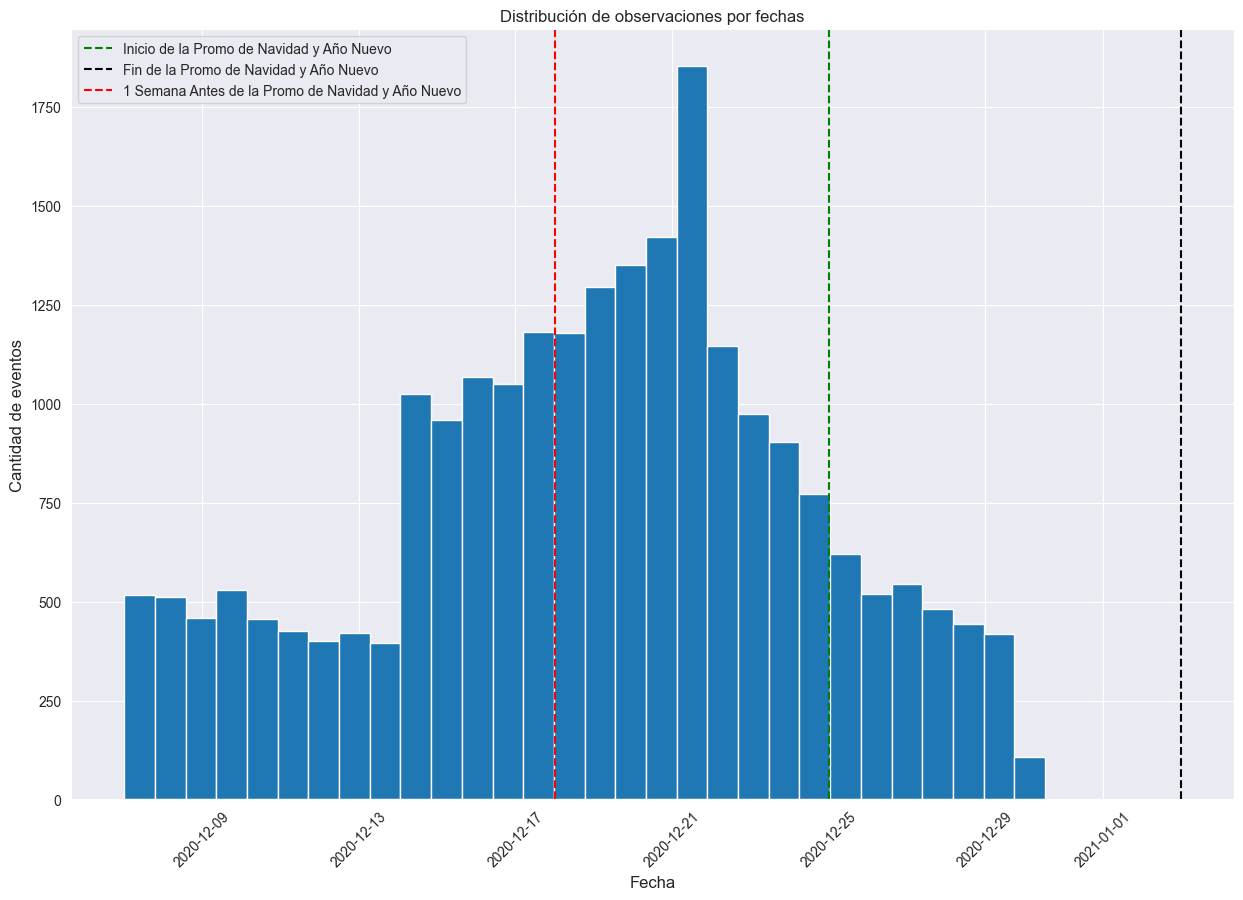

In [54]:
# visualizamos los eventos
x = ab_events['event_dt']
sns.set_style('darkgrid')

fig, ax = plt.subplots(figsize=(15, 10))
plt.grid(axis='both')
plt.xticks(rotation=45)
plt.title('Distribución de observaciones por fechas')
plt.grid(axis='both')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Cantidad de eventos', fontsize=12)

ax.hist(x,
        bins=30
       )

plt.axvline(x='2020-12-25', color='green', linestyle='--', label='Inicio de la Promo de Navidad y Año Nuevo')
plt.axvline(x='2021-01-03', color='black', linestyle='--', label='Fin de la Promo de Navidad y Año Nuevo')
plt.axvline(x='2020-12-18', color='red', linestyle='--', label='1 Semana Antes de la Promo de Navidad y Año Nuevo')

plt.legend()
plt.show()



Como podemos ver en el gráfico, los eventos dentro del test tienen una fuerte intersección con las actividades de marketing navideñas. Además, se debe tener en cuenta que el hecho de la Navidad (línea verde) en sí mismo potencialmente puede ser un indicador de aumento de ventas, ya que las personas compran regalos.

Este hecho compromete adicionalmente los resultados del test.

## Embudo de conversión

In [55]:
funnel_data = ab_events.groupby(['group', 'event_name'], as_index=False).agg(
    {'event_dt': 'count', 'user_id': 'nunique'}
).reindex([0, 2, 1, 3, 4, 6, 5, 7])
funnel_data

,group,event_name,event_dt,user_id
0,A,login,8124,2604
2,A,product_page,5227,1685
1,A,product_cart,2422,782
3,A,purchase,2536,833
4,B,login,2471,877
6,B,product_page,1327,493
5,B,product_cart,653,244
7,B,purchase,660,249


In [66]:
import plotly.graph_objects as go
from PIL import Image
import io
import os  # Asegúrate de incluir esta importación si falta

# Asumiendo que 'funnel_data' está correctamente definido y accesible

# Mejora en la preparación de los datos
df_group_a = funnel_data[funnel_data['group'] == 'A'].groupby('event_name').size().reset_index(name='user_id').sort_values(by='user_id', ascending=False)
df_group_b = funnel_data[funnel_data['group'] == 'B'].groupby('event_name').size().reset_index(name='user_id').sort_values(by='user_id', ascending=False)

fig = go.Figure()

# Trazado de datos para el grupo A
fig.add_trace(go.Funnel(
    name='Group "A"',
    y=df_group_a['event_name'],
    x=df_group_a['user_id']
))

# Trazado de datos para el grupo B
fig.add_trace(go.Funnel(
    name='Group "B"',
    y=df_group_b['event_name'],
    x=df_group_b['user_id']
))

fig.update_layout(title_text="Embudo de eventos para todo el conjunto de datos con separación por grupos")

# Comprobación y creación del directorio si no existe
output_path = "/Users/Acer/Documents/plotly_export"
output_file = f"{output_path}/funnel3.png"
os.makedirs(output_path, exist_ok=True)

# Guardar la figura como imagen
fig.write_image(output_file)
print(f"Image saved to {output_file}")

# Crear y mostrar una imagen utilizando PIL para confirmar que se guarda correctamente
img_bytes = fig.to_image(format="png")
image = Image.open(io.BytesIO(img_bytes))
image.show()


Image saved to /Users/Acer/Documents/plotly_export/funnel3.png


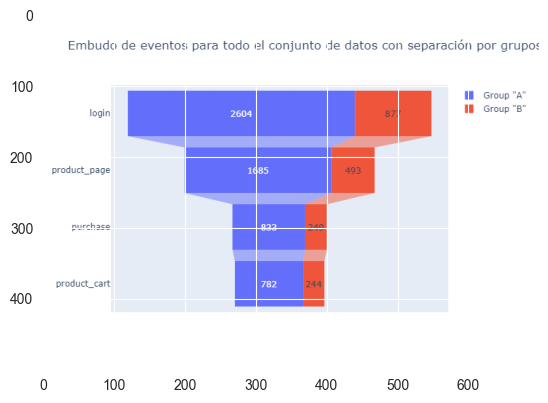

In [82]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name='Group "A"',
    y = funnel_data[funnel_data['group'] == 'A'].sort_values(by='user_id', ascending=False)['event_name'],
    x = funnel_data[funnel_data['group'] == 'A'].sort_values(by='user_id', ascending=False)['user_id']))


fig.add_trace(go.Funnel(
    name='Group "B"',
    y = funnel_data[funnel_data['group'] == 'B'].sort_values(by='user_id', ascending=False)['event_name'],
    x = funnel_data[funnel_data['group'] == 'B'].sort_values(by='user_id', ascending=False)['user_id']))

fig.update_layout(title_text="Embudo de eventos para todo el conjunto de datos con separación por grupos")



# Cargar y mostrar la imagen
img = mpimg.imread('/Users/Acer/Desktop/TipleTen/sprint_13/Proyecto Final/funnel3.png')
plt.imshow(img)
plt.show()




In [80]:
print('La conversión de usuarios logueados a compras en el grupo A es: {:.2f}%'.format(events_users.loc['purchase']['A']/events_users.loc['login']['A']*100))
print('La conversión de usuarios logueados a compras en el grupo B es: {:.2f}%'.format(events_users.loc['purchase']['B']/events_users.loc['login']['B']*100))
print('La relación de conversión a compras en el grupo B respecto al grupo A es: {:.2f}%'.format((events_users.loc['purchase']['B']/events_users.loc['login']['B'])/(events_users.loc['purchase']['A']/events_users.loc['login']['A'])*100))


La conversión de usuarios logueados a compras en el grupo A es: 31.61%
La conversión de usuarios logueados a compras en el grupo B es: 29.16%
La relación de conversión a compras en el grupo B respecto al grupo A es: 92.24%


Observamos una reducción en la conversión a compras de casi el 12% en el grupo de prueba. De acuerdo con la hipótesis previamente verificada sobre la igualdad de proporciones, tal diferencia es estadísticamente significativa. Por lo tanto, podemos hablar de un fracaso en el test.

## **Conclusiones**  
Durante el proceso de procesamiento de datos, se identificaron varios problemas que comprometen los datos utilizados para evaluar los resultados de la prueba A/B:  
- Según las especificaciones técnicas, la fecha de finalización del test fue el 4 de enero de 2021, sin embargo, en el conjunto de datos solo se reflejan eventos hasta finales de 2020, lo que sugiere la pérdida de parte de los datos durante el procesamiento o la descarga.  
- Se estableció que dentro del marco del test ocurre una superposición de participantes de dos tests.  
- Se determinó que los eventos dentro del test tienen una superposición significativa con las actividades de marketing navideñas.  
- Se encontró que solo el 55% de los usuarios de la muestra limpia generaron eventos en el período especificado. Existe la posibilidad de que ocurriera un error en el registro de la actividad de los usuarios o un problema durante el proceso de descarga de datos.  

**Análisis de los resultados de la prueba A/B:**  
- En el grupo A, la conversión a compra es 2.5 veces mayor.  
- Independientemente de la presencia/ausencia de un grupo de "usuarios dobles" en la muestra, los valores de conversión son comparables.  
- Se determinó que la conversión de un evento de inicio de sesión en el sitio a un evento de compra en el grupo B disminuyó en un 12%, lo que indica el fracaso en la prueba de la nueva funcionalidad.  

**Recomendación** - Demasiados factores diferentes comprometen la efectividad de la prueba, por lo que no se deberían considerar sus resultados como completamente objetivos. Si se tenían "grandes" expectativas respecto a la iniciativa probada, vale la pena considerar una nueva prueba en condiciones más aisladas y prestar especial atención a la recopilación de datos sobre la prueba realizada.